# IDENTIFICACION DE SISTEMAS - Laboratorio 4

Profesor: Jairo Alberto Cuéllar Guarnizo  
Programa: Ingeniería en Automatización y Control

In [2]:
from sympy import MatrixSymbol, Matrix, Identity
import sympy as sym
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
import control

# Elaborado por:

* Nombre 1, apellido 1
* Nombre 2, apellido 2

# 1. Discretizando un sistema en tiempo continuo

## Descripción del ejercicio:

Retome el sistema de tiempo continuo a manera de función de transferencia del Filtro paso bajos de Segundo orden obtenido en el desarrollo del ejercicio 1.

 ## 1.1. Obtención de G(z)
 
Use una sustitución con el retenedor de orden cero para obtener la función de transferencia en términos de z a partir de la función G(s).
 
 $$S = \frac{2(z-1)}{T(z+1)}$$
 
 $$z = e^{Ts}$$
 
 1. Defina un periodo de muestreo (T) 
 2. Obtenga la función de transferencia usando matemática simbólica.


In [3]:
s, z = sym.symbols('s z')
T=0.1
# Definir la función de transferencia en el dominio de Laplace
Num=[1e12, 1e15]
Den=[4e9, 1.5e12 , 5e14]
#G_s = (1e12 * s + 1e15) / (4e9 * s**2 + 1.5e12 * s + 5e14)

G_s= control.tf(Num,Den)

G_s2=control.c2d(G_s,0.01)

G_s2

TransferFunction(array([2.29433671, 0.35975226]), array([1.        , 0.30352674, 0.02351775]), 0.01)

In [4]:
dt = random.random()            # Tiempo de muestreo
# dt = 0.1
A = Matrix([-3])
B = Matrix([5])
u = 1

Adis = (dt*A).exp();
Bdis = A.inv()*(Adis-np.eye(len(B)))*B
Adis, Bdis, dt

(Matrix([[0.273913342050027]]),
 Matrix([[1.21014442991662]]),
 0.43164783083611813)

## 1.2. Espacio de estados

A partis de G(s) obtenga las matrices del modelo de estados (A, B, C, D) en tiempo continuo. Compare la respuesta al escalón a partir de la función de transferencia G(s) y a partir del modelo en espacio de estados.

In [5]:
Espacioestados= control.tf2ss(G_s2)

print("Matrices en espacio de estados:")
print("Matriz A", Espacioestados.A)
#print( A_continuous)
print("\n Matriz B", Espacioestados.B)
#print(B_continuous)
print("\n Matriz C", Espacioestados.C)
print("\nMatriz D:")
print(Espacioestados.D)

Matrices en espacio de estados:
Matriz A [[-0.30352674 -0.02351775]
 [ 1.          0.        ]]

 Matriz B [[1.]
 [0.]]

 Matriz C [[2.29433671 0.35975226]]

Matriz D:
[[0.]]


## 1.3. Discretice el modelo en espacio de estados

Use las ecuaciones vistas en clase y la aproximación de la serie de Taylor para discretizar el espacio de estados a partir del modelo en tiempo continuo.

1. Defina un periodo de muestreo (El mismo del paso 1)
2. Calcule A y B discretas

In [6]:
A_continuous = np.array([[-0.30352674 , -0.02351775], [1, 0]])
B_continuous = np.array([[1], [0]])

 

# Calcular las matrices discretas A y B utilizando la aproximacion de la serie de Taylor
A_discrete = np.eye(A_continuous.shape[0]) + A_continuous * T
B_discrete = B_continuous * T
print("Matriz A discreta:")
print(A_discrete)
print("\nMatriz B discreta:")
print(B_discrete)

sys_continuous = control.tf2ss(G_s)

Matriz A discreta:
[[ 0.96964733 -0.00235178]
 [ 0.1         1.        ]]

Matriz B discreta:
[[0.1]
 [0. ]]


## 1.4. Gráficas comparativas

1. Obtenga la respuesta al escalón del sistema original G(s)
2. Obtenga la respuesta al escalón del sistema discretizado G(z)
3. Obtenga la respuesta al escalón del modelo en espacio de estados en tiempo continuo.
4. Obtenga la respuesta al escalón del modelo en espacio de estados en tiempo discreto.

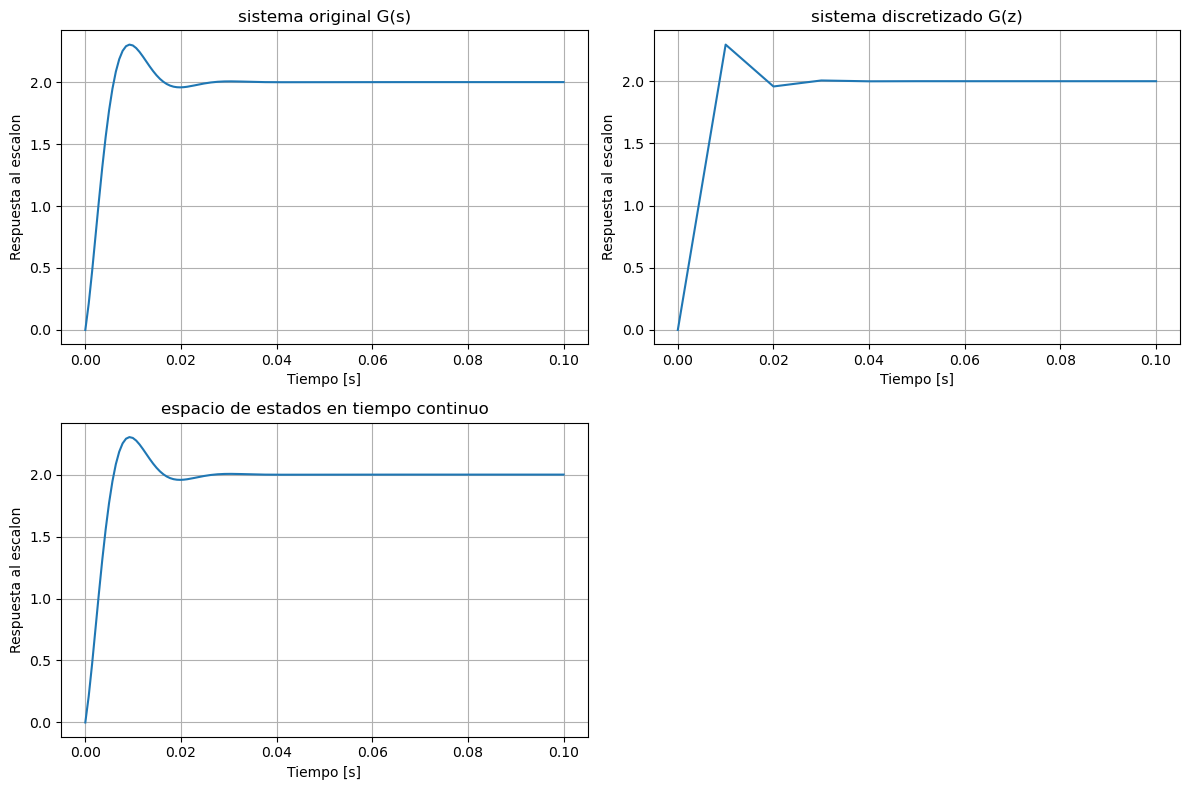

In [7]:
#respuesta al escalon del sistema original G(s)
t_gs, y_gs = control.step_response(G_s, T)

#respuesta al escalon del sistema discretizado G(z)
t_gd, y_gd = control.step_response(G_s2, T)

# respuesta al escalon del modelo en espacio de estados en tiempo continuo
t_ss_ct, y_ss_ct = control.step_response(sys_continuous, T)


# Graficar las respuestas
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(t_gs, y_gs)
plt.title('sistema original G(s)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Respuesta al escalon')
plt.grid(True)

plt.subplot(2, 2, 2)
plt.plot(t_gd, y_gd)
plt.title('sistema discretizado G(z)')
plt.xlabel('Tiempo [s]')
plt.ylabel('Respuesta al escalon')
plt.grid(True)

plt.subplot(2, 2, 3)
plt.plot(t_ss_ct, y_ss_ct)
plt.title('espacio de estados en tiempo continuo')
plt.xlabel('Tiempo [s]')
plt.ylabel('Respuesta al escalon')
plt.grid(True)

#plt.subplot(2, 2, 4)
#plt.plot(t_ss_dt, y_ss_dt)
#plt.title('espacio de estados en tiempo discreto')
#plt.xlabel('Tiempo [s]')
#plt.ylabel('Respuesta al escalon')
#plt.grid(True)

plt.tight_layout()
plt.show()

# 2. Polinomio Autoregresivo ARX

Utilice los datos capturados para la entrega anterior del proyecto y aplique los métodos discutidos en los noteboks 8_1 y 8_2.

Plantee 2 hipótesis diferentes usando el modelo ARX y para cada uno proceda de la siguiente manera:

2.1. Reconstruya la ecuación en diferencia usando la estructura del modelo entrada salida:

$$y_e[k] = a_1y[k-1] + ...+ a_{n_a}y[k-{n_a}] + b_0u[k]+ b_1u[k-1]+...+b_{n_b}u[k-{n_b}] + C_1$$

In [40]:
datos = pd.read_csv('Escalon2.csv', delimiter= ';')
datos['Pot'] = datos['Pot'].replace(',', '.').astype(float)
datos['Pot(%)'] = round(datos['Pot']*100/255, 2)
datos['Sensor'] = datos['Sensor'].str.replace(',', '.').astype(float)
datos['t'] = datos['t'].replace(',', '.').astype(float)
datos['t'] = datos['t']/1000
datos

,t,Pot,Sensor,Pot(%)
0,0.00,120.0,26.07,47.06
1,0.05,121.0,26.63,47.45
2,0.10,123.0,26.07,48.24
3,0.15,129.0,26.07,50.59
4,0.20,136.0,27.20,53.33
...,...,...,...,...
96,4.80,216.0,44.77,84.71
97,4.85,216.0,44.77,84.71
98,4.90,216.0,44.77,84.71
99,4.95,216.0,44.77,84.71


Text(0.5, 1.0, 'Escalon 1')

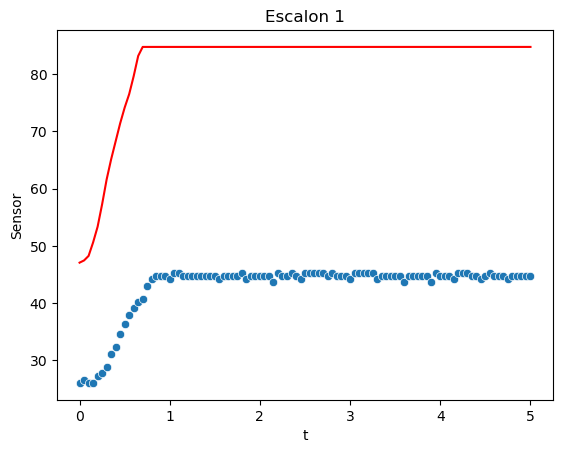

In [41]:
sns.scatterplot(data= datos, x= 't', y= 'Sensor')
plt.plot(datos.t, datos['Pot(%)'], color= 'red')
plt.title('Escalon 1')

In [42]:
datos['u1'] = datos['Pot(%)'].shift(1)
datos['u2'] = datos['Pot(%)'].shift(2)
datos['y1'] = datos.Sensor.shift(1)
datos['y2'] = datos.Sensor.shift(2)

datos = datos.drop(0, axis= 0).drop(1, axis= 0).reset_index()

datos

,index,t,Pot,Sensor,Pot(%),u1,u2,y1,y2
0,2,0.10,123.0,26.07,48.24,47.45,47.06,26.63,26.07
1,3,0.15,129.0,26.07,50.59,48.24,47.45,26.07,26.63
2,4,0.20,136.0,27.20,53.33,50.59,48.24,26.07,26.07
3,5,0.25,146.0,27.77,57.25,53.33,50.59,27.20,26.07
4,6,0.30,157.0,28.90,61.57,57.25,53.33,27.77,27.20
...,...,...,...,...,...,...,...,...,...
94,96,4.80,216.0,44.77,84.71,84.71,84.71,44.20,44.77
95,97,4.85,216.0,44.77,84.71,84.71,84.71,44.77,44.20
96,98,4.90,216.0,44.77,84.71,84.71,84.71,44.77,44.77
97,99,4.95,216.0,44.77,84.71,84.71,84.71,44.77,44.77


In [43]:
N = len(datos['t'])
a = 0
phi_e1 = np.array([datos.u1, datos.u2, datos.y1, datos.y2])
A = np.dot(phi_e1, phi_e1.transpose())
B = a*np.eye(A.shape[1])
C = A + B
C_inv = np.linalg.inv(C)
D = np.dot(phi_e1, datos.Sensor)
theta = np.dot(C_inv, D)
theta

array([0.26098756, 0.07291199, 0.21420915, 0.15480374])

Error cuadratico medio: 0.18338974781114312 
R cuadrado: 0.9907449904095569


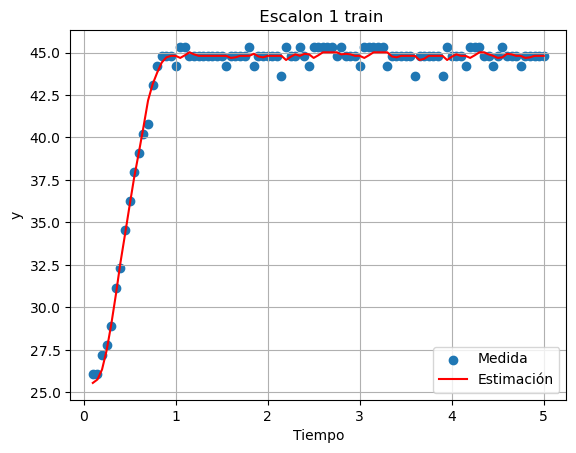

In [44]:
y_e1 = np.dot(phi_e1.transpose(), theta)
yn = datos.Sensor
plt.figure(0)
plt.scatter(datos.t, yn, label="Medida")
plt.plot(datos.t, y_e1, color='red', label="Estimación")
plt.title(" Escalon 1 train")
plt.xlabel("Tiempo")
plt.ylabel("y")
plt.legend()
plt.grid()
ecm_1 = mean_squared_error(yn, y_e1)
R2_1 = r2_score(yn, y_e1)
print(f'Error cuadratico medio: {ecm_1}',
      f'\nR cuadrado: {R2_1}')

In [45]:
datosTest = pd.read_csv('Escalon1.csv', delimiter= ";")
datosTest['Pot'] = datosTest['Pot'].replace(',', '.').astype(float)
datosTest['Pot(%)'] = round(datosTest['Pot']*100/255, 2)
datosTest['Sensor'] = datosTest['Sensor'].str.replace(',', '.').astype(float)
datosTest['t'] = datosTest['t'].replace(',', '.').astype(float)
datosTest['t'] = datosTest['t']/1000
datosTest

,t,Pot,Sensor,Pot(%)
0,0.00,129.0,26.63,50.59
1,0.05,135.0,27.20,52.94
2,0.10,140.0,27.77,54.90
3,0.15,151.0,28.33,59.22
4,0.20,162.0,30.03,63.53
...,...,...,...,...
58,2.90,253.0,48.17,99.22
59,2.95,254.0,49.30,99.61
60,3.00,254.0,49.30,99.61
61,3.05,254.0,49.30,99.61


Text(0.5, 1.0, 'Escalon 2')

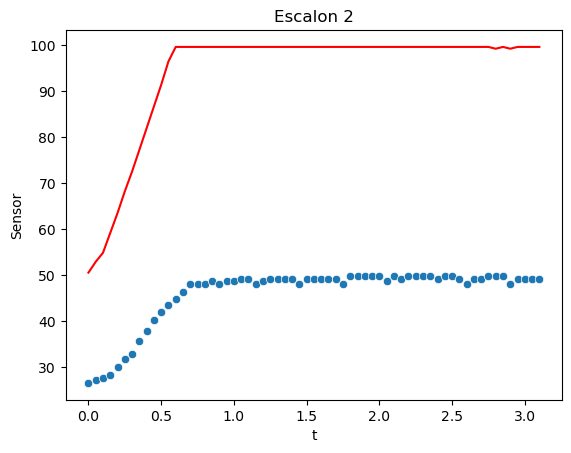

In [46]:
sns.scatterplot(data= datosTest, x= 't', y= 'Sensor')
plt.plot(datosTest.t, datosTest['Pot(%)'], color= 'red')
plt.title('Escalon 2')

In [47]:
datosTest['u1'] = datosTest['Pot(%)'].shift(1)
datosTest['u2'] = datosTest['Pot(%)'].shift(2)
datosTest['y1'] = datosTest.Sensor.shift(1)
datosTest['y2'] = datosTest.Sensor.shift(2)

datosTest = datosTest.drop(0, axis= 0).drop(1, axis= 0).reset_index()
datosTest

,index,t,Pot,Sensor,Pot(%),u1,u2,y1,y2
0,2,0.10,140.0,27.77,54.90,52.94,50.59,27.20,26.63
1,3,0.15,151.0,28.33,59.22,54.90,52.94,27.77,27.20
2,4,0.20,162.0,30.03,63.53,59.22,54.90,28.33,27.77
3,5,0.25,174.0,31.73,68.24,63.53,59.22,30.03,28.33
4,6,0.30,185.0,32.87,72.55,68.24,63.53,31.73,30.03
...,...,...,...,...,...,...,...,...,...
56,58,2.90,253.0,48.17,99.22,99.61,99.22,49.87,49.87
57,59,2.95,254.0,49.30,99.61,99.22,99.61,48.17,49.87
58,60,3.00,254.0,49.30,99.61,99.61,99.22,49.30,48.17
59,61,3.05,254.0,49.30,99.61,99.61,99.61,49.30,49.30


In [48]:
datosTest['y_e'] = (datosTest.u1 * 0.261 + datosTest.u2 * 0.072 + datosTest.y1 * 0.214 + datosTest.y2 * 0.155) * 0.96
datosTest

,index,t,Pot,Sensor,Pot(%),u1,u2,y1,y2,y_e
0,2,0.10,140.0,27.77,54.90,52.94,50.59,27.20,26.63,26.311939
1,3,0.15,151.0,28.33,59.22,54.90,52.94,27.77,27.20,27.167386
2,4,0.20,162.0,30.03,63.53,59.22,54.90,28.33,27.77,28.585142
3,5,0.25,174.0,31.73,68.24,63.53,59.22,30.03,28.33,30.396230
4,6,0.30,185.0,32.87,72.55,68.24,63.53,31.73,30.03,32.476483
...,...,...,...,...,...,...,...,...,...,...
56,58,2.90,253.0,48.17,99.22,99.61,99.22,49.87,49.87,49.482317
57,59,2.95,254.0,49.30,99.61,99.22,99.61,48.17,49.87,49.062307
58,60,3.00,254.0,49.30,99.61,99.61,99.22,49.30,48.17,49.112256
59,61,3.05,254.0,49.30,99.61,99.61,99.61,49.30,49.30,49.307357


Error cuadratico medio: 0.4633417265039517 
R cuadrado: 0.9857957701741316


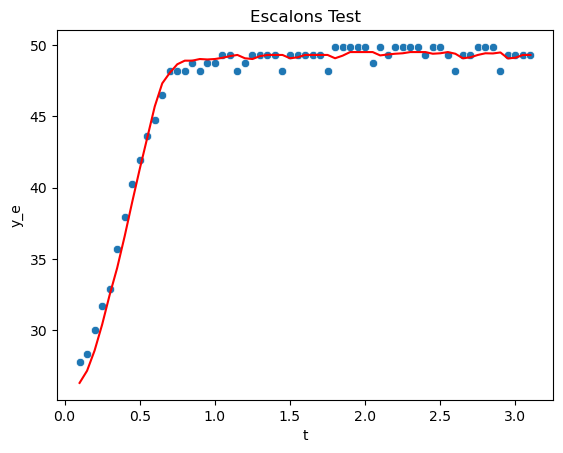

In [49]:
sns.lineplot(data= datosTest, x= 't', y= 'y_e', color= 'red')
sns.scatterplot(data= datosTest, x= 't', y= 'Sensor')
plt.title('Escalons Test')
ecm_2 = mean_squared_error(datosTest.Sensor, datosTest.y_e)
R2_2 = r2_score(datosTest.Sensor, datosTest.y_e)
print(f'Error cuadratico medio: {ecm_2}',
      f'\nR cuadrado: {R2_2}')

## Ecuación en diferencias obtenida.

$$y_e[k] = 0.214y[k-1] + 0.155y[k-2] + 0.261u[k-1]+ 0.072u[k-2]

2.2. Obtenga una función de transferencia estimada usando los coeficientes hallados en el punto anterior:

$$G(z) = \frac{b_1z^{-1}+b_2z^{-2}+...+b_{n_b}z^{-{n_b}}}{1+a_1z^{-1}+...+a_{n_a}z^{-{n_a}}}$$

In [52]:
dt_tf = control.TransferFunction([0.261, 0.072], [1, -0.214, -0.155], dt=0.05)
dt_tf

TransferFunction(array([0.261, 0.072]), array([ 1.   , -0.214, -0.155]), 0.05)

(0.0, 1.0)

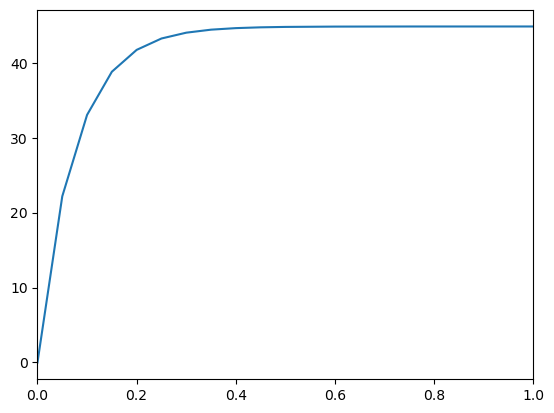

In [62]:
t, h = control.step_response(dt_tf)
plt.plot(t, h * 85)
plt.xlim(0, 1)

## Conclusiones

* En el punto 2, la entrada con la que se excita el sistema para extraer las ecuaciones en diferencia simula un escalon, Sin embargo, no es un escalon como tal, es por eso que no podemos comparar la respuesta obtenida con el step_response de la funcion de transferencia discreta y la que se obtuvo con la ecuación en diferencias.
* Se puede evidenciar en el segundo punto (ARX) que cuando el estado de la entrada esta muy cercana al 100% el sistema pierde el comportamiento lineal, es por eso que en el test del modelo se tiene que multiplicar por una ganancia K para que ajuste de mejor manera.
* Se puede evidenciar en las graficas comparativas del punto uno la similitud entre los tres modelos: funcion de transferencia continua, funcion de transferencia discreta y modelo en espacio de estados; esto traduce que el proceso y los resultados obtenidos fueron los correctos.